# Features extraction with VGG16, ResNet50 and other models!
-----------------------------------------------------------------------------------------------------------------------------------------------

##### Information about the notebook 📘:
- This project aims to deepen knowledges in CNNs, especially in features extraction and images similarity computation. I decided to work with VGG16 and ResNet50 and to compare their cosine similarity performances.

- If the built model has the parameter ```include_top = True``` (by default), then the model will be composed of all layers: 'feature learning block' + 'classification block'. In this way, we aim to make a **prediction**. Otherwise, ```if include_top = False```, the classification block is omitted and we seek to **extract features**.

- To extract visual features, the input images must be **preprocessed** (reshaping, RGB->BGR conversion, zero-centering with dataset). **Feature maps output from each block** of the model are collected in a single pass, then an image of each is created. There are five main blocks in the image (e.g. block1, block2, etc.) that end in a pooling layer. You can **choose blocks** to visualize by the layers index: ```idx```.

- To compute how similar are two images, the metric **cosine similarity** was used on feature vectors extracted from both images. The more similar the images are, the more ```sim_cos``` tends to 1 (see function ```compute_similarity_img()```).

- In this context, **data augmentation** is applied to increase the dataset and for cosine similarity performances visualization.

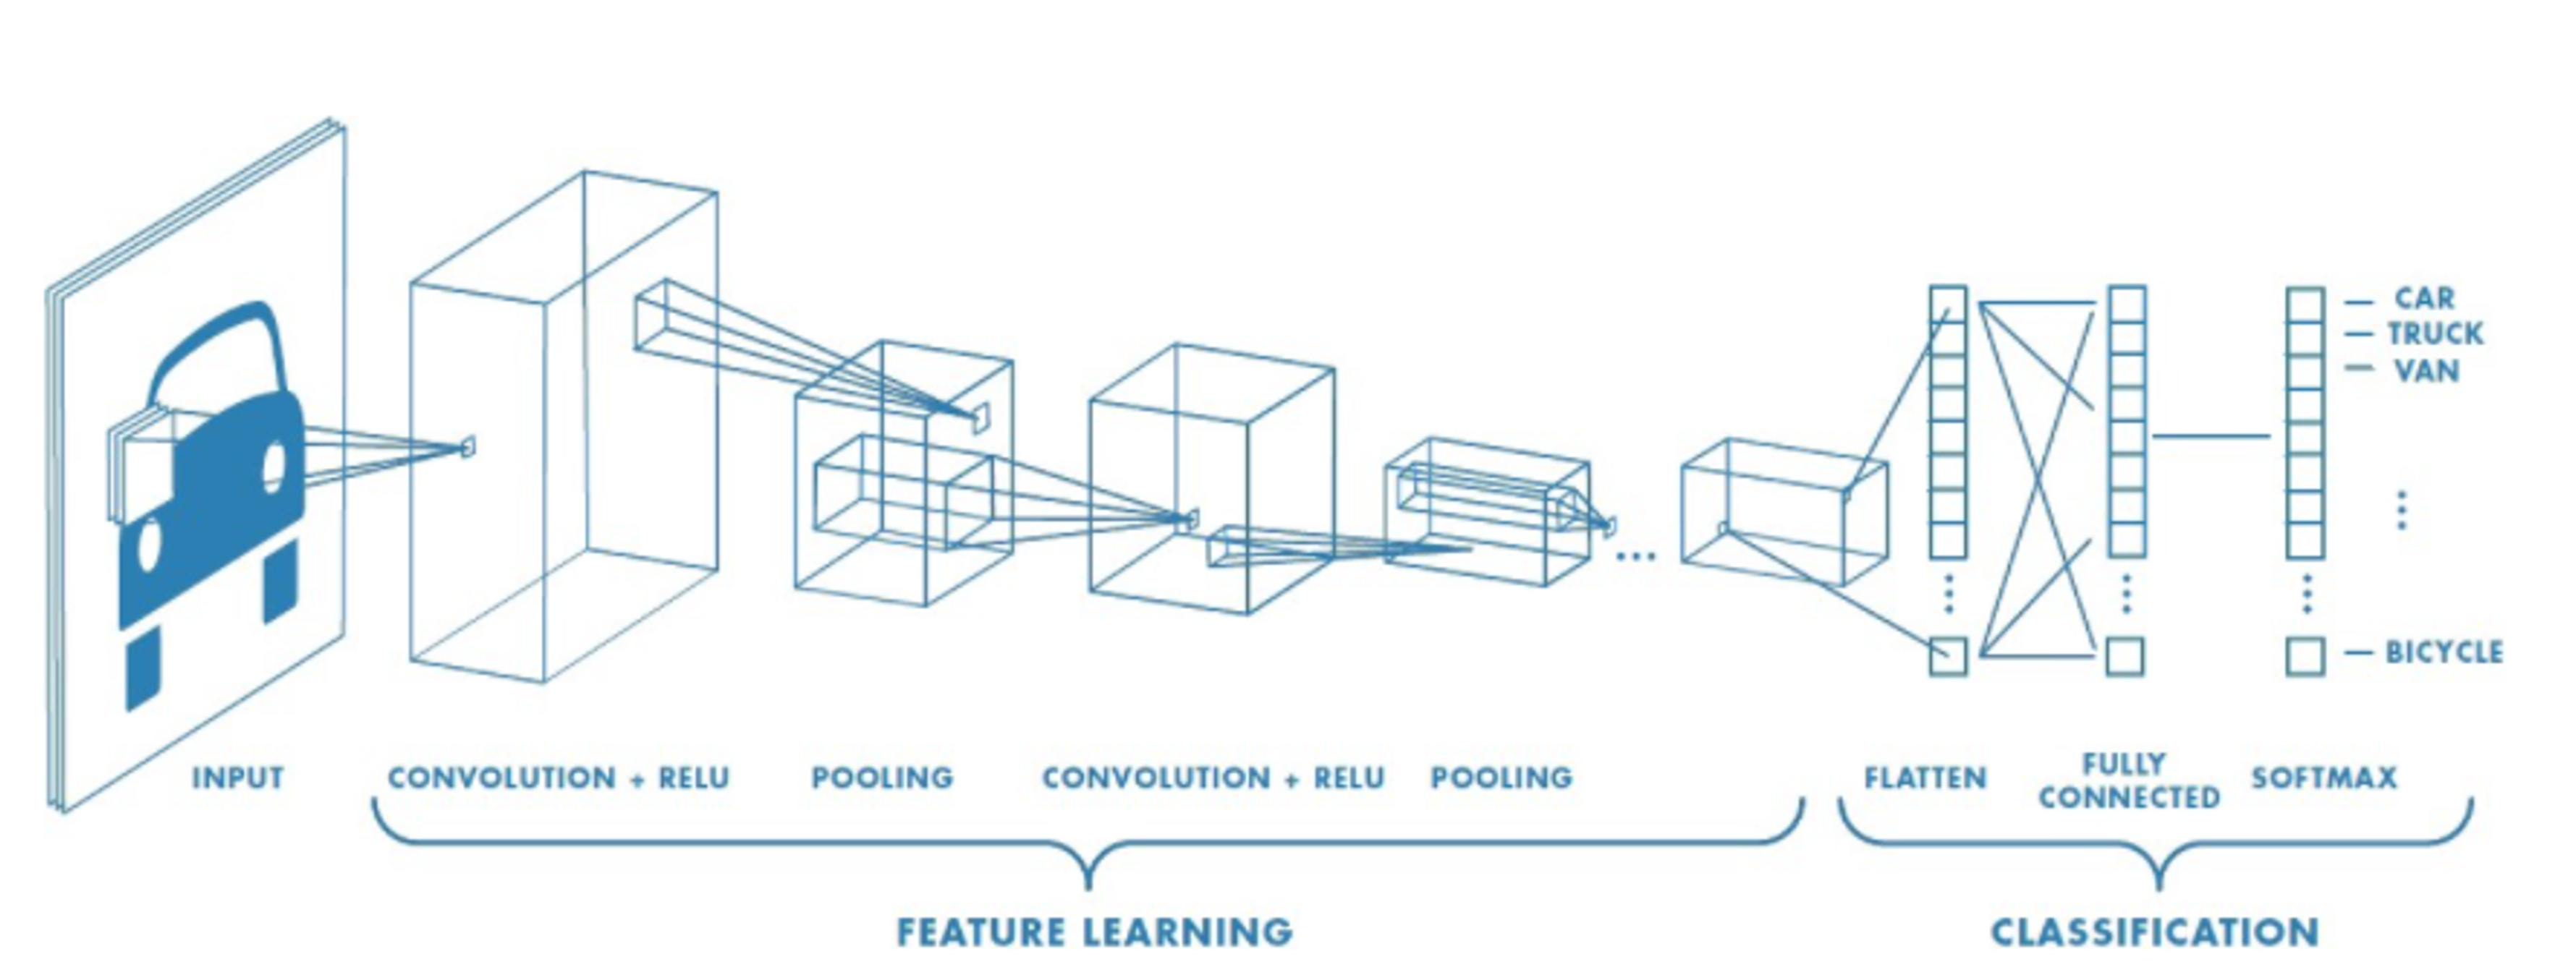

##### Summary 📂:

 - Part 1 - Imports

 - Part 2 - Load model
 
 - Part 3 - Image class prediction

 - Part 4 - Feature vector extraction

 - Part 5 - Visualization of feature maps from main blocks

 - Part 6 - Similarity computation between images (using feature vector)

 - Part 7 - Data augmentation

 - Part 8 - Comparison cosine similarity between VGG16 and ResNet50

# Part 1 - Imports

##### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

import cv2
from IPython.display import HTML, display
from glob import glob
from PIL import Image
import time

##### General function

In [2]:
def create_folder(folder_name):
    """ Create folder if there is not
    Args:
        folder_name: String, folder name
    Returns:
        None
    """
    if not os.path.isdir(f"../models/{folder_name}"):
        os.makedirs(f"../models/{folder_name}")
        print(f"Folder '../models/{folder_name}' created")

# Part 2 - Load model

In [3]:
def load_model(model_name, include_top=True):
    """ Load pre-trained Keras model
    Args:
        model_name: String, name of model to load
        include_top: String, the model is buildt with 'feature learning block' + 'classification block'
    Returns:
        model: Keras model instance
    """
    if selected_model in available_models:
        # Load a Keras instance
        try:
            if model_name == 'vgg16':
                model = VGG16(weights='imagenet', include_top=include_top)
            elif model_name == 'resnet50':
                model = ResNet50(weights='imagenet', include_top=include_top)
            print(f">> '{model.name}' model successfully loaded!")
        except:
            print(f">> Error while loading model '{selected_model}'")
    
    # Wrong selected model
    else:
        print(f">> Error: there is no '{selected_model}' in {available_models}")
    
    return model

##### Model selection

In [4]:
available_models = ['vgg16', 'resnet50']
selected_model = 'vgg16'

model = load_model(selected_model, include_top=True)

>> 'vgg16' model successfully loaded!


##### Information about the model

In [5]:
def get_img_size_model(model):
    """Returns image size for image processing to be used in the model
    Args:
        model: Keras model instance 
    Returns:
        img_size_model: Tuple of integers, image size
    """
    model_name = model.name
    if model_name == "vgg16":
        img_size_model = (224, 224)
    elif model_name == "resnet50":
        img_size_model = (224, 224)
    else:
        img_size_model = (224, 224)
        print("Warning: model name unknown. Default image size: {}".format(img_size_model))
        
    return img_size_model


def get_layername_feature_extraction(model):
    """ Return the name of last layer for feature extraction   
    Args:
        model: Keras model instance
    Returns:
        layername_feature_extraction: String, name of the layer for feature extraction
    """
    model_name = model.name
    if model_name == "vgg16":
        layername_feature_extraction = 'fc2'
    elif model_name == "resnet50":
        layername_feature_extraction = 'predictions'
    else:
        layername_feature_extraction = ''
        print("Warning: model name unknown. Default layername: '{}'".format(layername_feature_extraction))
    
    return layername_feature_extraction

In [6]:
# Verify model architecture
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##### Function + list each layers of the model

In [7]:
def get_layers_list(model):
    """Get a list of layers from a model
    Args:
        model: Keras model instance
    Returns:
        layers_list: List of string of layername
    """
    layers_list = []
    for i in range(len(model.layers)):
        layer = model.layers[i]        
        layers_list.append(layer.name)
        
    return layers_list

In [8]:
# List each layers of the model
layers_list = get_layers_list(model)
print("Architecture of the {} model:\n{}".format(model.name, layers_list))

Architecture of the vgg16 model:
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


# Part 3 - Image class prediction

##### Function

In [9]:
def image_processing(img_array):
    """ Preprocess image to be used in a keras model instance
    Args:
        img_array: Numpy array of an image which will be predicte
    Returns:
        processed_img = Numpy array which represents the processed image
    """    
    # Expand the shape
    img = np.expand_dims(img_array, axis=0)

    # Convert image from RGB to BGR (each color channel is zero-centered with respect to the ImageNet dataset, without scaling)
    processed_img = preprocess_input(img)
    
    return processed_img



def make_prediction(model, img_path, display_img=True):
    """Make a prediction of an image by passing in the model
    
    Args:
        model: Keras model instance used to do the classification.
        img_path: String to the image path which will be predicted
        display_img: Boolean to decid to show image. Defaults to True
        
    Returns:
        predicted_class: String which represents the class of the predicted image from ImageNet
    """
    img_type = os.path.basename(img_path).split(".")[0]
    
    # Image processing
    img_size_model = get_img_size_model(model)
    img = image.load_img(img_path, target_size=img_size_model)
    img_arr = np.array(img)
    img_ = image_processing(img_arr)

    preds = model.predict(img_)
    top_preds = decode_predictions(preds)
    predicted_class = top_preds[0][0][1]
    predicted_class_percentage = top_preds[0][0][2]*100
    
    print('Top 5 predictions:')
    for i in range(len(top_preds[0])):
        print("  {} >>>>> {}".format(i+1, top_preds[0][i]))
    
    if display_img:
        print()
        plt.axis('off')
        plt.title("({}) Original image: {}\nPrediction: {} ({:.2f}%)".format(model.name, img_type, predicted_class, predicted_class_percentage))
        plt.imshow(img_arr)
        
    return predicted_class

##### Image selection 

In [10]:
img_dir = '../data'
img_path_list = ['vase.jpg', 'vase2.jpg', 'flowerpot.jpg']
index = 0
img_path = os.path.join(img_dir, img_path_list[index])

##### Image processing to be used in the model

Input image shape: (1, 224, 224, 3)


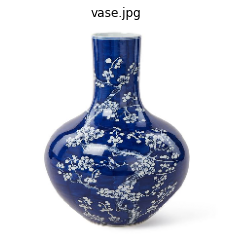

In [11]:
# Image processing
img_size_model = get_img_size_model(model)
img = image.load_img(img_path, target_size=img_size_model)
x_ = np.array(img)

# Display image
plt.axis('off')
plt.title(img_path_list[index])
plt.imshow(x_/255.)

# Expand the shape
x = np.expand_dims(x_, axis=0)

# Convert image from RGB to BGR (each color channel is zero-centered with respect to the ImageNet dataset, without scaling)
x = preprocess_input(x)
print('Input image shape:', x.shape)

Top 5 predictions:
  1 >>>>> ('n04522168', 'vase', 0.98658574)
  2 >>>>> ('n03443371', 'goblet', 0.0045557152)
  3 >>>>> ('n03950228', 'pitcher', 0.001769956)
  4 >>>>> ('n03916031', 'perfume', 0.0016308117)
  5 >>>>> ('n04579145', 'whiskey_jug', 0.001238644)



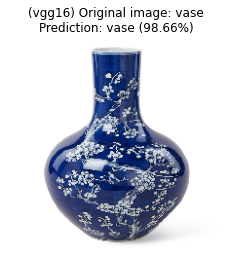

In [12]:
predicted_class = make_prediction(model, img_path, display_img=True)

# Part 4 -  Feature vector extraction

In [13]:
def get_feature_vector(model, img_path):
    """ Get a feature vector extraction from an image by using a keras model instance
    Args:
        model: Keras model instance used to do the classification.
        img_path: String to the image path which will be predicted
    Returns:
        feature_vect: List of visual feature from the input image
    """
    
    # Creation of a new keras model instance without the last layer
    layername_feature_extraction = get_layername_feature_extraction(model)
    model_feature_vect = Model(inputs=model.input, outputs=model.get_layer(layername_feature_extraction).output)
    
    # Image processing
    img_size_model = get_img_size_model(model)
    img = image.load_img(img_path, target_size=img_size_model)
    img_arr = np.array(img)
    img_ = image_processing(img_arr)
    
    # Visual feature extraction
    feature_vect = model_feature_vect.predict(img_)
    
    return feature_vect

##### Get and display (entire or sample) feature vector 

In [14]:
feature_vect = get_feature_vector(model, img_path)

In [15]:
print_all = False # print the whole vector [vgg16 -> 1x4096, resnet50 -> 1x2048]
print('Feature vector shape:', feature_vect.shape)

if print_all:
    np.set_printoptions(threshold=np.inf, suppress=True)
    print('Feature vector (all): {}'.format(feature_vect[0]))
    np.set_printoptions(threshold=0)
else:
    print('Feature vector (truncated): {}'.format(feature_vect[0]))

Feature vector shape: (1, 4096)
Feature vector (truncated): [0.        2.5234904 0.        ... 0.        0.        0.       ]


# Part 5 - Visualization of feature maps from main blocks

In [16]:
def get_feature_maps(model, layers_indexes, img_path):
    """ Get feature maps from a model from specific layers
    Args:
        model: Keras model instance used to do the feature extraction.
        layers_indexes: indexes of feature maps extraction
        img_path: String to the image path which feature will be extracted 
    Returns:
        feature_maps: Numpy array of feature maps
    """
    # Image processing
    img_size_model = get_img_size_model(model)
    img = image.load_img(img_path, target_size=img_size_model)
    img_arr = np.array(img)
    img_ = image_processing(img_arr)
    
    # Indexes of the last convolutional layer in each block
    output_model = [model.layers[i].output for i in layers_indexes]
    
    # Creation of a new keras model instance with specific layers
    model_feature_maps = Model(inputs=model.input, outputs=output_model)
    feature_maps = model_feature_maps.predict(img_)
    
    return feature_maps

In [17]:
def show_feature_maps(model, feature_maps, idx):
    """Display all features maps extracted from blocks
    Args:
        model: Keras model instance used to do the feature extraction
        feature_maps: Numpy array of feature maps extracted from blocks
        idx: indexes of feature maps extraction
    """
    square = 8
    block = 0
    layers_list = get_layers_list(model)
    
    # Processing when there is only one element in feature_maps
    feature_maps_ = []
    if len(feature_maps) == 1:
        feature_maps_.append(feature_maps)
    else:
        feature_maps_ = feature_maps

    # Plot feature_maps for each block
    for fmap in feature_maps_:
        # Plot all 64 maps in an 8x8 squares
        ix = 1
        blockname = layers_list[idx[block]].split("_")[0]

        fig = plt.figure()
        fig.suptitle("Feature maps extracted from {} in the {} model".format(blockname, model.name), fontsize=12)

        for _ in range(square):
            for _ in range(square):
                ax = plt.subplot(square, square, ix)
                ax.set_xticks([])
                ax.set_yticks([])

                plt.imshow(fmap[0, :, :, ix-1], cmap = 'gray')
                ix += 1
        plt.show()
        block += 1

        if fmap is not feature_maps_[-1]:
            print("-"*100)

##### Get feature maps

In [18]:
# indexes of the last convolutional layer in each block
idx = [2, 5, 9, 13, 17] # [block1, block2, block3, block4, block5] for vgg16
feature_maps = get_feature_maps(model, idx, img_path)

In [19]:
print("Architecture of the {} model:\n\n{}".format(model.name, layers_list))
print('\nFeatures shape ({}): {}'.format(layers_list[idx[0]], feature_maps[0].shape))

Architecture of the vgg16 model:

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']

Features shape (block1_conv2): (1, 224, 224, 64)


##### Show feature maps

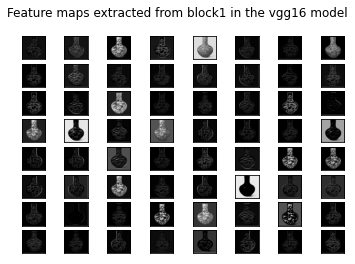

----------------------------------------------------------------------------------------------------


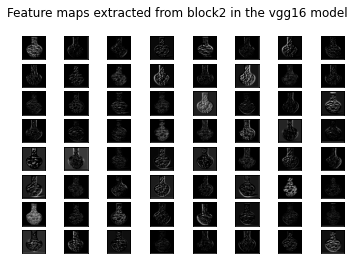

----------------------------------------------------------------------------------------------------


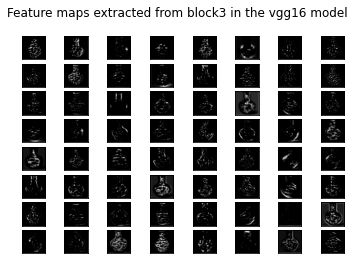

----------------------------------------------------------------------------------------------------


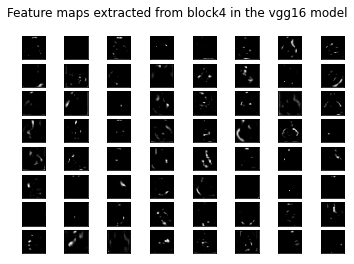

----------------------------------------------------------------------------------------------------


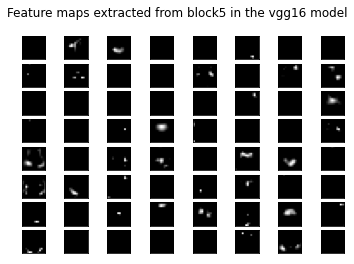

In [20]:
if model.name == 'vgg16':
    show_feature_maps(model, feature_maps, idx)

# Part 6 - Similarity computation between images (using feature vector)

##### Functions

In [21]:
from scipy import spatial

def calculate_similarity(vector1, vector2):
    """Compute similarities between two images using 'cosine similarities'
    Args:
        vector1: Numpy vector to represent feature extracted vector from image 1
        vector2: Numpy vector to represent feature extracted vector from image 1
    Returns:
        sim_cos: Float to describe the similarity between both images
    """
    sim_cos = 1-spatial.distance.cosine(vector1, vector2)
    
    return sim_cos

In [22]:
def compute_similarity_img(model, img_path_1, img_path_2):
    """ Return a cosine similarity between both images and display them in HTML
    Args:
        model: Keras model instance used to do the feature extraction
        img_path_1: String to the image 1 path
        img_path_2: String to the image 2 path
    Returns:
        sim_cos: Float to describe the similarity between both images
    """
    filename1 = os.path.basename(img_path_1).split(".")[0]
    filename2 = os.path.basename(img_path_2).split(".")[0]
    
    # Compute feature vector extracted
    fea_vec_img1 = get_feature_vector(model, img_path_1)
    fea_vec_img2 = get_feature_vector(model, img_path_2)
    
    # Compute cosine similarity
    sim_cos = calculate_similarity(fea_vec_img1, fea_vec_img2)
    
    # Read images
    img_size_model = get_img_size_model(model)
    im1 = cv2.resize(cv2.imread(img_path_1), dsize=img_size_model, interpolation = cv2.INTER_AREA)
    im2 = cv2.resize(cv2.imread(img_path_2), dsize=img_size_model, interpolation = cv2.INTER_AREA)
    
    # Concatenate images horizontally
    im12 = cv2.hconcat([im1, im2])
    
    # Save concatenated image
    dst_dir_cos_sim = "../report/cos_sim"
    create_folder(dst_dir_cos_sim)
    dst_dir = f"{dst_dir_cos_sim}/{model.name}"
    create_folder(dst_dir)
    
    new_filename = f"{filename1}_{filename2}"
    cv2.imwrite(f"{dst_dir}/{new_filename}.jpg", im12)

    # Display images with cosine similarity result with HTML
    thumb = "<div style='margin: 0px;'> ({}) {}/{}: cos_sim = {:.4f}</div>".format(model.name, filename1, filename2, sim_cos)
    thumb += ''.join( ["<img style='width: 300px; margin: 0px; float: left; border: 1px solid black;' src='%s'/>" %str(s)
                       for s in sorted(glob('{}/{}.jpg'.format(dst_dir, new_filename))) ])
    
    display(HTML(thumb))
    print()
    
    return sim_cos

##### Compute similarities between two images usign cosine similarity method on feature vector extracted

In [23]:
# img_path_list = ['vase.jpg', 'vase2.jpg', 'flowerpot.jpg']
img1 = os.path.join(img_dir, img_path_list[0])
img2 = os.path.join(img_dir, img_path_list[1])
img3 = os.path.join(img_dir, img_path_list[2])

In [24]:
sim_cos_11 = compute_similarity_img(model, img1, img1)
sim_cos_12 = compute_similarity_img(model, img1, img2)
sim_cos_13 = compute_similarity_img(model, img1, img3)

# Part 7 - Data augmentation

##### Function

In [25]:
def get_augmented_img_path_list(img_path, img_generator, nb_img):
    """ Performs a data augmentation
    Args:
        img_path: String to the image path
        img_generator: Tensor which generate batches of tensor image data with real-time data augmentation
        nb_img: Integer, number of augmented images
    Returns:
        aug_img_list: Numpy array of augmented images
    """
    dir_aug_img = "../report/augmented_img"
    create_folder(dir_aug_img)
    
    # Read img
    img = plt.imread(img_path)
    filename = os.path.basename(img_path).split(".")[0]
    img_ = np.expand_dims(img, 0)
    
    # Generate batches of augmented images from the original image
    aug_iter = gen.flow(img_)
    
    # Get nb_img samples of augmented images
    aug_img = [next(aug_iter)[0].astype(np.uint8) for i in range(nb_img)]
    
    aug_img_path_list = []
    for i in range(len(aug_img)):
        # Save augmented images
        new_filename = f"{filename}AI{i}".format(filename, i)
        aug_img_path = f"{dir_aug_img}/{new_filename}.jpg"
        aug_img_to_save = Image.fromarray(aug_img[i])
        aug_img_to_save.save(aug_img_path)
        
        # Add augmented images
        aug_img_path_list.append(aug_img_path)
    
    return aug_img_path_list

##### Parameters for image augmentation

In [26]:
# Generate batches of tensor image data with real-time data augmentation.
gen = ImageDataGenerator(
    rotation_range=30, # Int: degree range for random rotations
    width_shift_range=0.1, # Float: fraction of total width, if < 1, or pixels if >= 1
    height_shift_range=0.1, # Float: fraction of total height, if < 1, or pixels if >= 1
    shear_range=0.15, # Float: shear Intensity (shear angle in counter-clockwise direction in degrees)
    zoom_range=0.1, # Float: range for random zoom
    channel_shift_range=10., # Float: range for random channel shifts
    horizontal_flip=True # Boolean: randomly flip inputs horizontally
)

# Number of augmented images
N = 10

##### Display augmented images

In [27]:
augmented_img_path_list = get_augmented_img_path_list(img1, gen, N)

In [28]:
augmented_img_display = ''.join( ["<img style='width: 180px; margin: 0px; float: left; border: 1px solid black;' src='%s' />" % str(s)
                       for s in augmented_img_path_list ])

display(HTML(augmented_img_display))

##### Compute similarities between original image and augmented images

In [29]:
compute_similarity_img(model, img1, img1)
for au_img in augmented_img_path_list:
    compute_similarity_img(model, img1, au_img)
print()

# Part 8 - Comparison cosine similarity between VGG16 and ResNet50

##### Load new model

In [30]:
if model.name == "vgg16":
    new_model_name = "resnet50"
else:
    new_model_name = "vgg16"
new_model = load_model(new_model_name)
print(f"New model loaded is: '{new_model.name}'")

>> 'resnet50' model successfully loaded!
New model loaded is: 'resnet50'


##### Verification of the architecture and make a comparison of cosine similarities results with a loaded model

In [31]:
# Verify loaded model architecture
new_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
print("Comparison between the original loaded model ({}) and another loaded model ({})\n".format(model.name, new_model.name))

# Images of vases
compute_similarity_img(model, img1, img1)
compute_similarity_img(new_model, img1, img1)

compute_similarity_img(model, img1, img2)
compute_similarity_img(new_model, img1, img2)

compute_similarity_img(model, img1, img3)
compute_similarity_img(new_model, img1, img3)

Comparison between the original loaded model (vgg16) and another loaded model (resnet50)




Folder '../models/../report/cos_sim/resnet50' created


0.07747440040111542